In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings("ignore")

In [2]:
# Loading the Dataset
heartDatasetlink = r"https://raw.githubusercontent.com/Yesdani20/Datasets/refs/heads/main/Heart_Disease_Dataset.csv"
try:
    heartDataframe = pd.read_csv(heartDatasetlink)
    if heartDataframe.empty:
        print("The given dataset is empty")
    else:
        print(f"The dataset is loaded, It has {heartDataframe.shape[0]} rows and {heartDataframe.shape[1]} columns")
except FileNotFoundError:
    print(f"The file at {heartDatasetlink} was not found, Please check the file path")
except pd.errors.EmptyDataError:
    print("The file exists but is empty, Please re-check the contents in the file")
except Exception as e:
    print(f"An error occurred loading the dataset: {e}")

The dataset is loaded, It has 918 rows and 12 columns


In [3]:
print("Information About Dataset")
print(heartDataframe.info())
print()

Information About Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None



In [4]:
# Finding Missing Values
print("Finding Missing Values in Dataset")
print(heartDataframe.isnull().sum())
print()

Finding Missing Values in Dataset
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64



In [5]:
print("Dataframe before Encoding:")
print(heartDataframe)
print()

Dataframe before Encoding:
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  


In [6]:
# Checking for Categorical Features in the Dataframe
print("Checking for Categorical Features in the Dataframe")
heartdfCategoricalCol = heartDataframe.select_dtypes(include='object').columns.tolist()
for name in heartdfCategoricalCol:
    uniqueValues = heartDataframe[name].unique()
    print(f"Types of Values in \"{name}\":", uniqueValues)
print()

Checking for Categorical Features in the Dataframe
Types of Values in "Sex": ['M' 'F']
Types of Values in "ChestPainType": ['ATA' 'NAP' 'ASY' 'TA']
Types of Values in "RestingECG": ['Normal' 'ST' 'LVH']
Types of Values in "ExerciseAngina": ['N' 'Y']
Types of Values in "ST_Slope": ['Up' 'Flat' 'Down']



In [7]:
# Preprocessing the Data
label_Encoder = LabelEncoder()
# Changing Categorical Features to Numerical
for name in heartdfCategoricalCol:
    heartDataframe[name] = label_Encoder.fit_transform(heartDataframe[name])
print("Dataframe after Encoding:")
print(heartDataframe)
print()

Dataframe after Encoding:
     Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0     40    1              1        140          289          0           1   
1     49    0              2        160          180          0           1   
2     37    1              1        130          283          0           2   
3     48    0              0        138          214          0           1   
4     54    1              2        150          195          0           1   
..   ...  ...            ...        ...          ...        ...         ...   
913   45    1              3        110          264          0           1   
914   68    1              0        144          193          1           1   
915   57    1              0        130          131          0           1   
916   57    0              1        130          236          0           0   
917   38    1              2        138          175          0           1   

     MaxHR  ExerciseAngin

In [8]:
# Seperating Features and Target Labels
heartFeat = heartDataframe.iloc[:, :-1]
heartTarg = heartDataframe.iloc[:, -1]

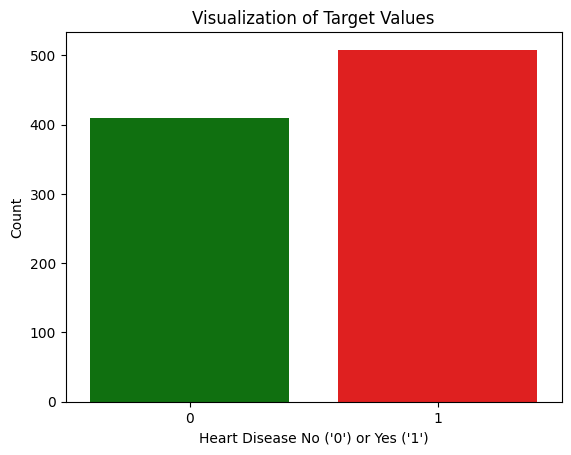

In [9]:
# Visualization of Target Labels
sns.countplot(x=heartTarg, palette=["green", "red"])
plt.xlabel("Heart Disease No ('0') or Yes ('1')")
plt.ylabel("Count")
plt.title("Visualization of Target Values")
plt.show()
print()

In [10]:
# Percentage difference between target values
print("Information About the Graph")
yesHeartDisease, noHeartDisease = heartTarg.value_counts()
totalValues = heartTarg.count()
print(f"{(noHeartDisease / totalValues) * 100}% of data predicts which is {noHeartDisease} No Heart Disease")
print(f"{(yesHeartDisease / totalValues) * 100}% of data predicts which is {yesHeartDisease} Yes Heart Disease")
print()

Information About the Graph
44.66230936819172% of data predicts which is 410 No Heart Disease
55.33769063180828% of data predicts which is 508 Yes Heart Disease



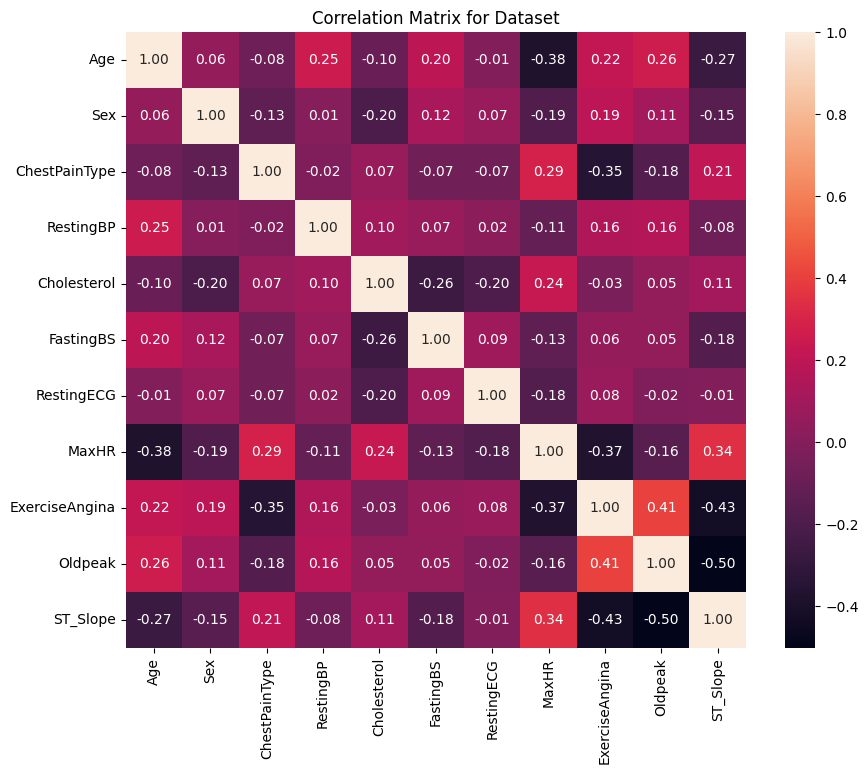

In [11]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
corre = heartFeat.corr()
sns.heatmap(corre, annot=True, fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Dataset")
plt.show
print()

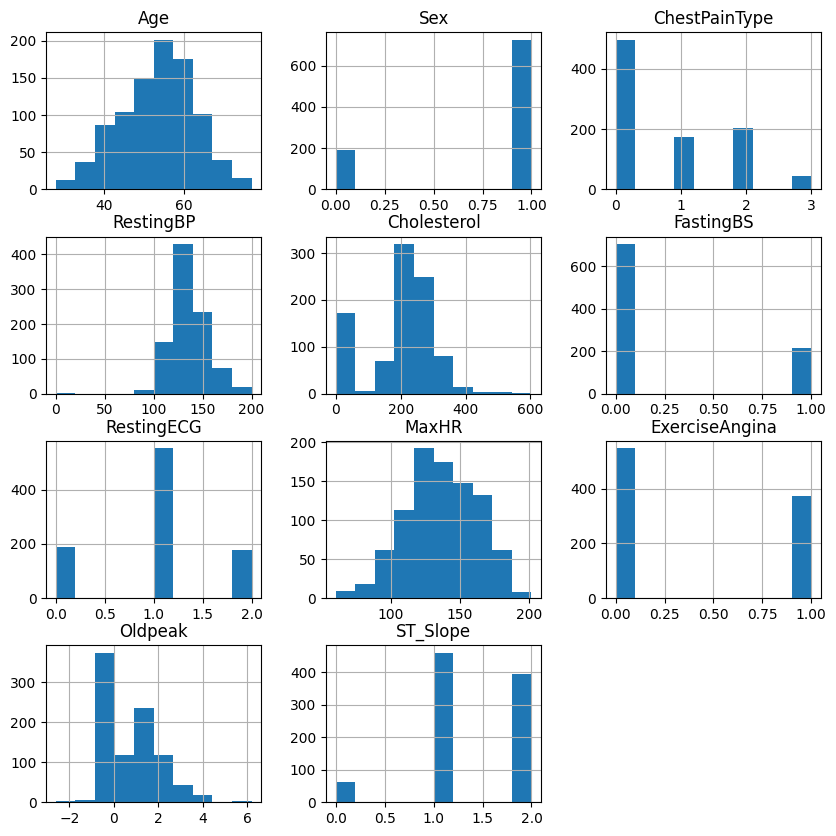

In [12]:
# Histogram for all Features
heartFeat.hist(figsize=(10, 10))
plt.title("Histogram for all Features")
plt.show()
print()

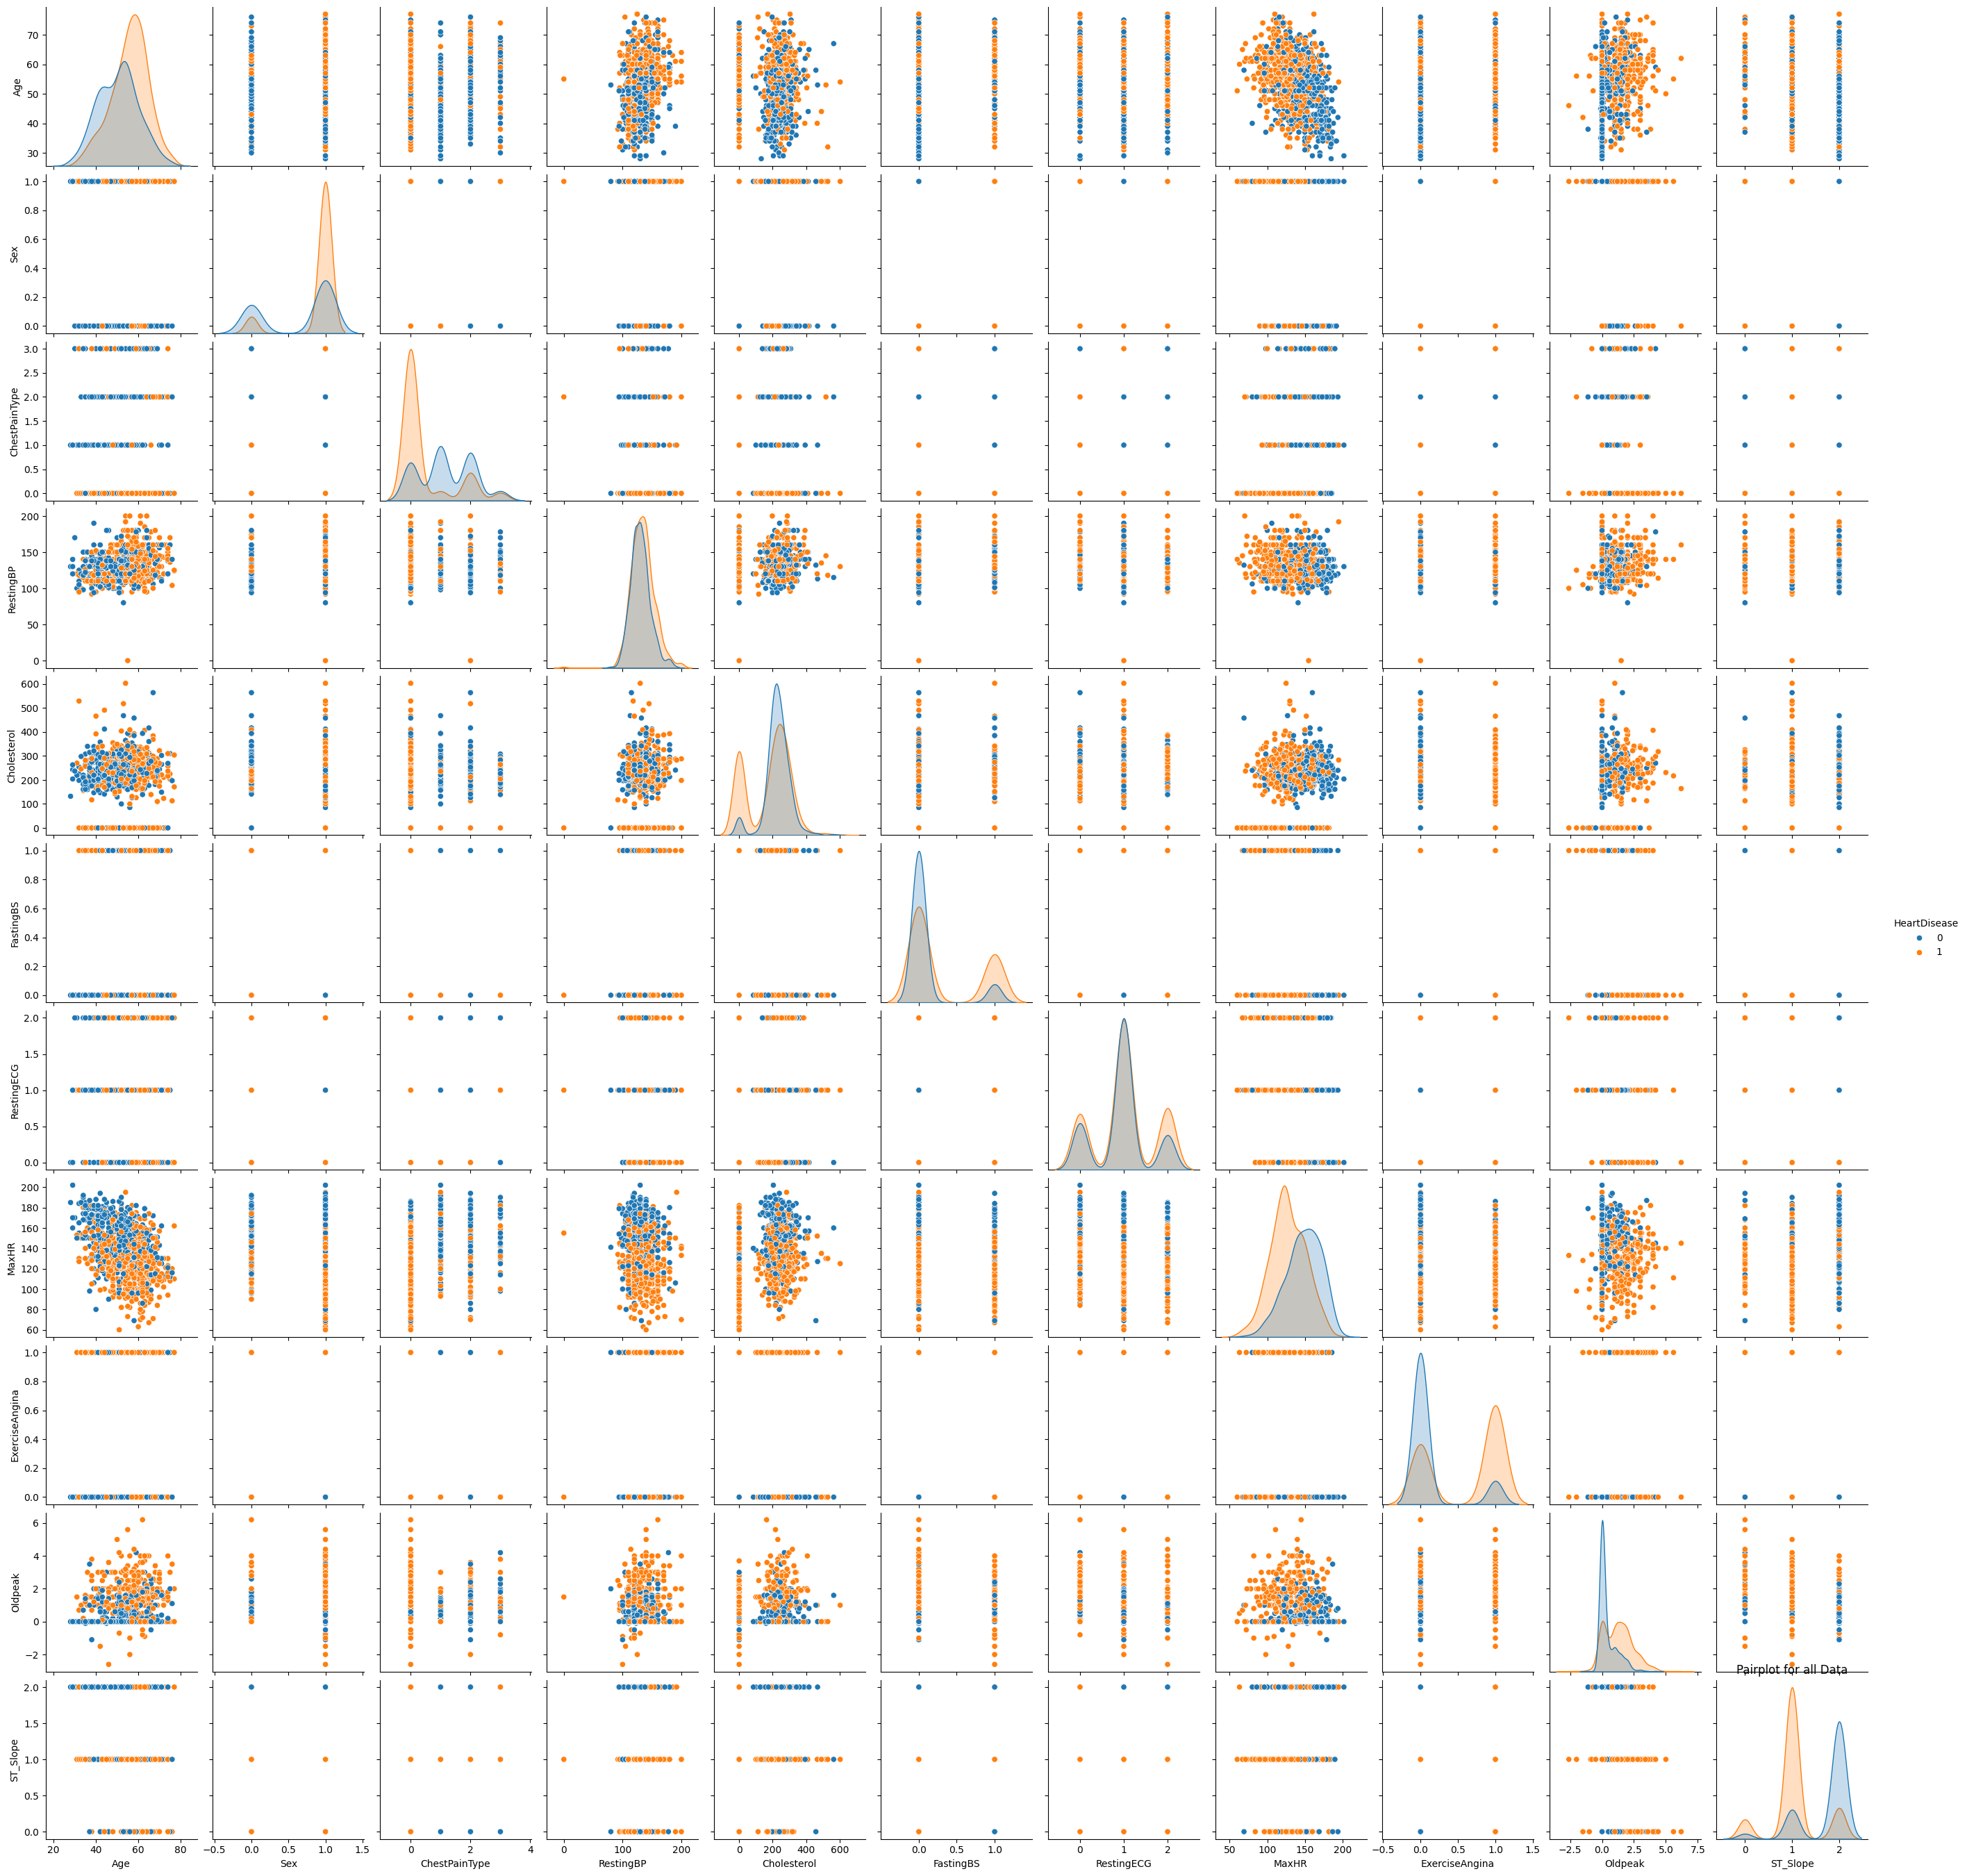

In [13]:
# Pairplot
sns.pairplot(heartDataframe, hue="HeartDisease")
plt.title("Pairplot for all Data")
plt.show()
print()

In [14]:
# Splitting Training and Testing Data
heartFeat_Train, heartFeat_Test, heartTarg_Train, heartTarg_Test = train_test_split(heartFeat, heartTarg, test_size=0.2, random_state=42)

In [15]:
# Normalizing the Training Data
scaler = StandardScaler()
heartFeat_Train_std = scaler.fit_transform(heartFeat_Train)
heartFeat_Test_std = scaler.transform(heartFeat_Test)

In [16]:
# Reshaping data for LSTM
heartFeat_TrainReshaped = heartFeat_Train_std.reshape((heartFeat_Train_std.shape[0], heartFeat_Train_std.shape[1], 1))
heartFeat_TestReshaped = heartFeat_Test_std.reshape((heartFeat_Test_std.shape[0], heartFeat_Test_std.shape[1], 1))

In [17]:
# Plotting for Confusion Matrix
def plotConfusionMatrix(matrix, al):
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {al}")
    plt.show()
    print()

In [18]:
# Plotting for ROC_AUC Curve
def plotROCAUC(alg, fpR, tpR, rOCAUc):
    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpR, tpR, color="darkorange", lw=2, label=f"ROC Curve {rOCAUc}")
    plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{alg}_ROC_AUC_Curve")
    plt.legend(loc="upper left")
    plt.show()
    print()

In [19]:
def perform_Metrics(alg, yTarg_TrainFold, yTarg_TestFold, yPred, yProb):
    # True Negative, False Positive, False Negative, True Positive
    tN, fP, fN, tP = confusion_matrix(yTarg_TestFold, yPred).ravel()
    if alg == "Random_Forest":
        print(f"Confusion Matrix for Random Forest Train Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)
    elif alg == "K-Nearset_Neighbors":
        print(f"Confusion Matrix for K-Nearest Neighbor Train Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)
    elif alg == "Long_Short-Term_Memory":
        print(f"Confusion Matrix for Long Short Term Memory Train Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)

    if alg == "Random_Forest_Test":
        print(f"Confusion Matrix for Random Forest Test Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)
        fpR, tpR, _ = roc_curve(yTarg_TestFold, yProb)
        if len(fpR) > 1 and len(tpR) > 1:
            rOCAUc = auc(fpR, tpR)
            plotROCAUC(alg, fpR, tpR, rOCAUc)
        else:
            raise ValueError("Insufficient data points for ROC Curve.")
    elif alg == "K-Nearset_Neighbors_Test":
        print(f"Confusion Matrix for K-Nearest Neighbor Test Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)
        fpR, tpR, _ = roc_curve(yTarg_TestFold, yProb)
        if len(fpR) > 1 and len(tpR) > 1:
            rOCAUc = auc(fpR, tpR)
            plotROCAUC(alg, fpR, tpR, rOCAUc)
        else:
            raise ValueError("Insufficient data points for ROC Curve.")
    elif alg == "Long_Short-Term_Memory_Test":
        print(f"Confusion Matrix for Long Short Term Memory Test Data: \n{confusion_matrix(yTarg_TestFold, yPred)}")
        plotConfusionMatrix(confusion_matrix(yTarg_TestFold, yPred), alg)
        fpR, tpR, _ = roc_curve(yTarg_TestFold, yProb)
        if len(fpR) > 1 and len(tpR) > 1:
            rOCAUc = auc(fpR, tpR)
            plotROCAUC(alg, fpR, tpR, rOCAUc)
        else:
            raise ValueError("Insufficient data points for ROC Curve.")

    # True Positive Rate
    if (tP + fN) > 0:
        tPR = tP / (tP + fN)
    else:
        tPR = 0
    # True Negative Rate
    if (tN + fP) > 0:
        tNR = tN / (tN + fP)
    else:
        tNR = 0
    # False Positive Rate
    if (tN + fP) > 0:
        fPR = fP / (tN + fP)
    else:
        fPR = 0
    # False Negative Rate
    if (tP + fN) > 0:
        fNR = fN / (tP + fN)
    else:
        fNR = 0
    # False Discovery Rate
    if (tP + fP) > 0:
        fDR = fP / (tP + fP)
    else:
        fDR = 0
    # Recall or Sensitivity
    if (tP + fN) > 0:
        r = tP / (tP + fN)
    else:
        r = 0
    # Precision (Quality of Positive Prediction)
    if (tP + fP) > 0:
        p = tP / (tP + fP)
    else:
        p = 0
    # F1 Measure
    if (2 * tP + fP + fN) > 0:
        f1 = (2 * tP) / (2 * tP + fP + fN)
    else:
        f1 = 0
    # Accuracy
    if (tP + fP + fN + tN) > 0:
        accur = (tP + tN) / (tP + fP + fN + tN)
    else:
        accur = 0
    # Error Rate
    if (tP + fP + fN + tN) > 0:
        erRt = (fP + fN) / (tP + fP + fN + tN)
    else:
        erRt = 0
    # Balanced Accuracy
    baccur = (tPR + tNR) / 2
    # True Skill Statistics
    tSS = (tP / (tP + fN)) - (fP / (fP + tN))
    # Heidke Skill Score
    if (((tP + fN) * (fN + tN)) + ((tP + fP) * (fP + tN))) > 0:
        hSS = (2 * ((tP * tN) - (fP * fN))) / (((tP + fN) * (fN + tN)) + ((tP + fP) * (fP + tN)))
    else:
        hSS = 0
    aucccc = roc_auc_score(yTarg_TestFold, yProb)
    brier = brier_score_loss(yTarg_TestFold, yProb)
    # Calculate Baseline Brier Score
    baselineProb = [yTarg_TrainFold.mean()] * len(yTarg_TestFold)
    brierBaseline = brier_score_loss(yTarg_TestFold, baselineProb)
    if brierBaseline > 0:
        brierSkill = 1 - (brier / brierBaseline)
    else:
        brierSkill = 0
    metricsDt = {
        "True Positive (TP)": tP,
        "True Negative (TN)": tN,
        "False Positive (FP)": fP,
        "False Negative (FN)": fN,
        "Sensitivity (TPR)": tPR,
        "Specificity (TNR)": tNR,
        "False Positive Rate (FPR)": fPR,
        "False Negative Rate (FNR)": fNR,
        "Recall (r)": r,
        "Precision (P)": p,
        "F1 Measure (F1)": f1,
        "Accuracy": accur,
        "Error Rate": erRt,
        "Balanced Accuracy": baccur,
        "True Skill Statistics (TSS)": tSS,
        "Heidke Skill Score (HSS)": hSS,
        "ROC_AUC Score": aucccc,
        "Brier Score": brier,
        "Brier Skill Score": brierSkill
    }
    return metricsDt

In [20]:
# Random Forest Function
def randomForest(algori, rF_Lt, heartX_TrainFold_std, heartY_TrainFold, heartX_TestFold_std, heartY_TestFold):
    rFImp = RandomForestClassifier(n_estimators=100, random_state=42)
    rFImp.fit(heartX_TrainFold_std, heartY_TrainFold)
    rFPred = rFImp.predict(heartX_TestFold_std)
    rFProb =rFImp.predict_proba(heartX_TestFold_std)[:, 1]
    rFMetrics = perform_Metrics(algori, heartY_TrainFold, heartY_TestFold, rFPred, rFProb)
    rF_Lt.append(rFMetrics)
    return rF_Lt

In [21]:
# K-Nearest Neighbors Function
def kNearest_Neighbors(algori, kNN_Lt, heartX_TrainFold_std, heartY_TrainFold, heartX_TestFold_std, heartY_TestFold):
    knnImp = KNeighborsClassifier(n_neighbors=7)
    knnImp.fit(heartX_TrainFold_std, heartY_TrainFold)
    kNNPred = knnImp.predict(heartX_TestFold_std)
    kNNProb = knnImp.predict_proba(heartX_TestFold_std)[:, 1]
    kNNMetrics = perform_Metrics(algori, heartY_TrainFold, heartY_TestFold, kNNPred, kNNProb)
    kNN_Lt.append(kNNMetrics)
    return kNN_Lt

In [22]:
# Long Short Term Memory Function
def lSTM(algori, lstm_Lt, heartX_TrainFold_lstm, heartY_TrainFold, heartX_TestFold_lstm, heartY_TestFold):
    lstmImp = Sequential()
    lstmImp.add(LSTM(64, input_shape=(heartX_TrainFold_lstm.shape[1], 1), activation='relu', return_sequences=True))
    lstmImp.add(Dropout(0.2))
    lstmImp.add(LSTM(32, activation='relu'))
    lstmImp.add(Dropout(0.2))
    lstmImp.add(Dense(1, activation='sigmoid'))
    lstmImp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    lstmImp.fit(heartX_TrainFold_lstm, heartY_TrainFold, epochs=10, batch_size=16, verbose=0)
    lstmPred = (lstmImp.predict(heartX_TestFold_lstm) > 0.5).astype("int32")
    lstmProb = lstmImp.predict(heartX_TestFold_lstm).flatten()
    lstmMetrics = perform_Metrics(algori, heartY_TrainFold, heartY_TestFold, lstmPred, lstmProb)
    lstm_Lt.append(lstmMetrics)
    return lstm_Lt

In [23]:
rFtrain_Lt = []
kNNtrain_Lt = []
lstmtrain_Lt = []
fold = []

Fold Number: 1
Confusion Matrix for Random Forest Train Data: 
[[30  4]
 [ 7 33]]


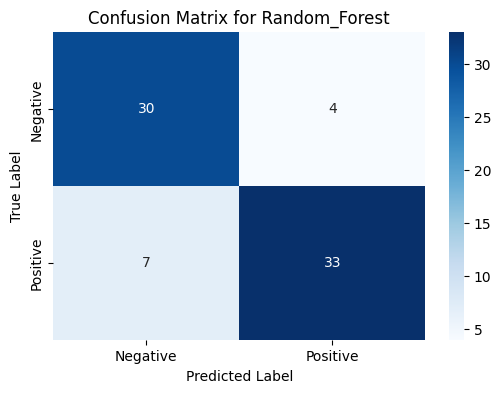


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[29  5]
 [ 4 36]]


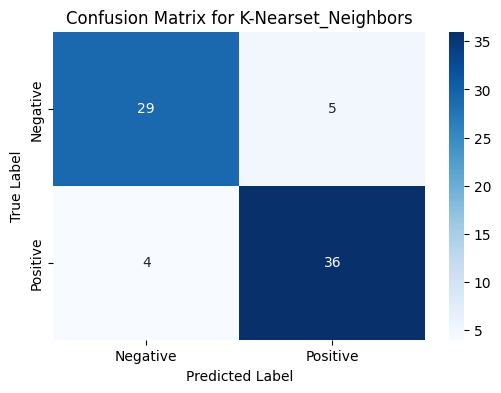


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix for Long Short Term Memory Train Data: 
[[28  6]
 [11 29]]


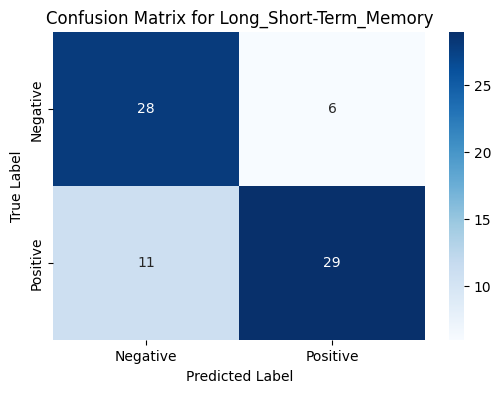


Fold Number: 2
Confusion Matrix for Random Forest Train Data: 
[[29  5]
 [ 2 38]]


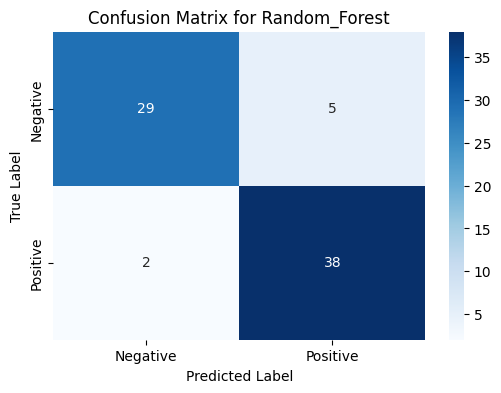


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[27  7]
 [ 1 39]]


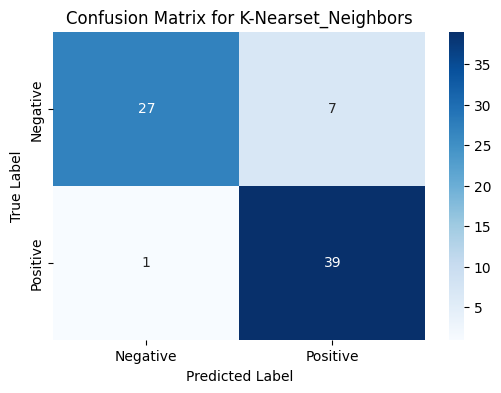


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix for Long Short Term Memory Train Data: 
[[21 13]
 [ 3 37]]


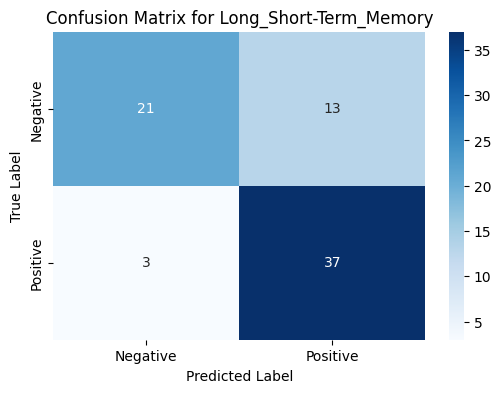


Fold Number: 3
Confusion Matrix for Random Forest Train Data: 
[[29  5]
 [ 6 34]]


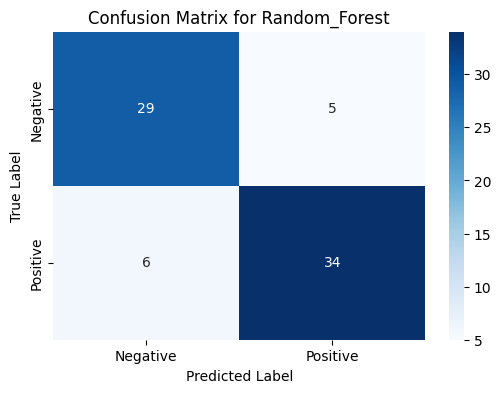


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[29  5]
 [ 6 34]]


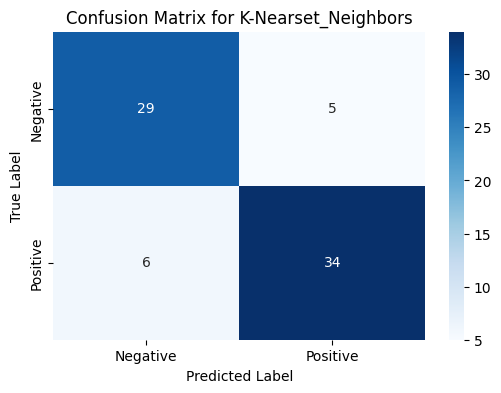


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002078BA22B60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Long Short Term Memory Train Data: 
[[26  8]
 [11 29]]


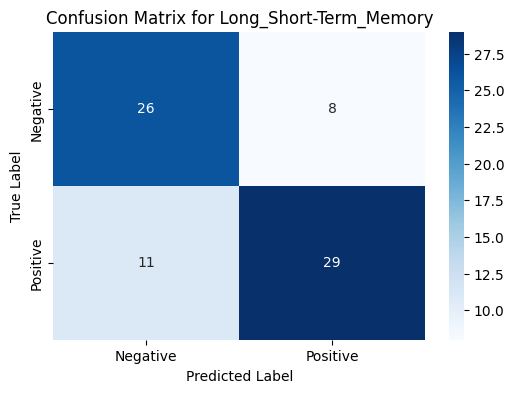


Fold Number: 4
Confusion Matrix for Random Forest Train Data: 
[[24  9]
 [ 5 36]]


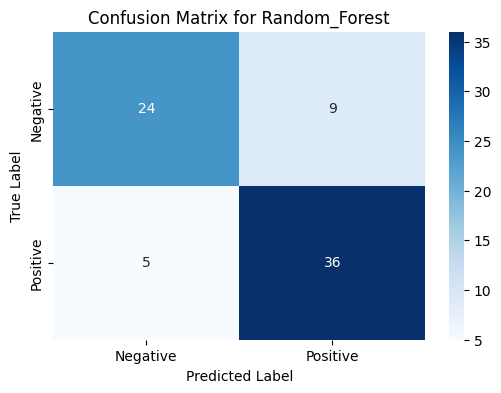


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[24  9]
 [ 4 37]]


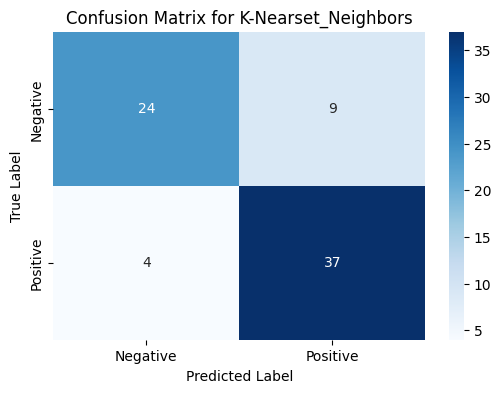


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002078F17AB60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Confusion Matrix for Long Short Term Memory Train Data: 
[[26  7]
 [ 7 34]]


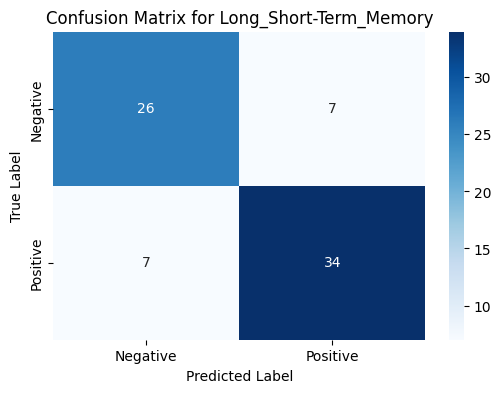


Fold Number: 5
Confusion Matrix for Random Forest Train Data: 
[[28  5]
 [ 5 35]]


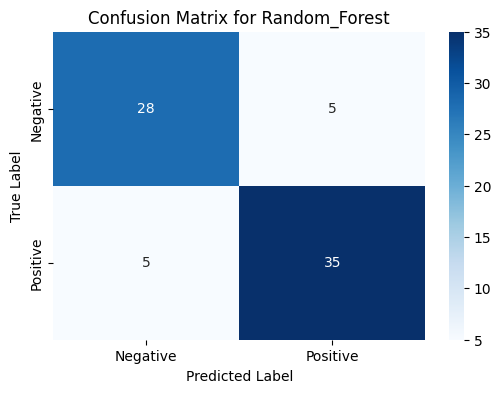


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[27  6]
 [ 4 36]]


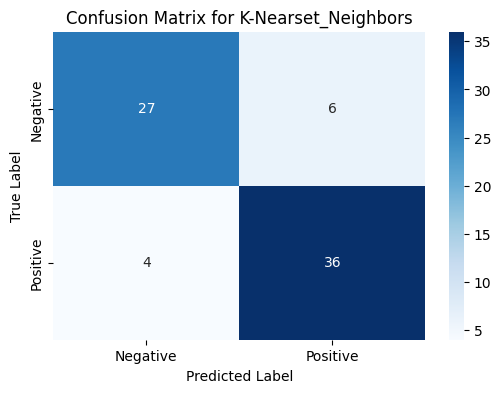


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix for Long Short Term Memory Train Data: 
[[25  8]
 [ 5 35]]


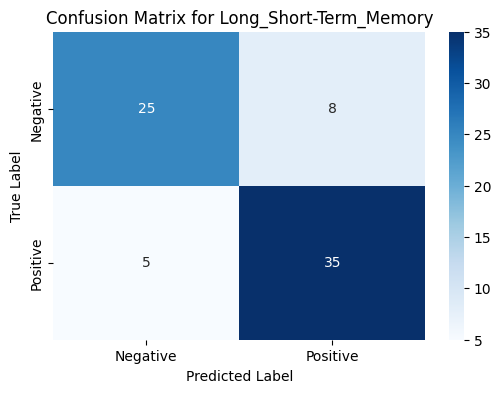


Fold Number: 6
Confusion Matrix for Random Forest Train Data: 
[[25  8]
 [ 8 32]]


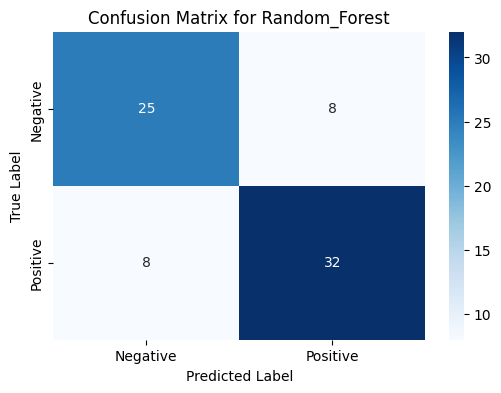


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[28  5]
 [ 6 34]]


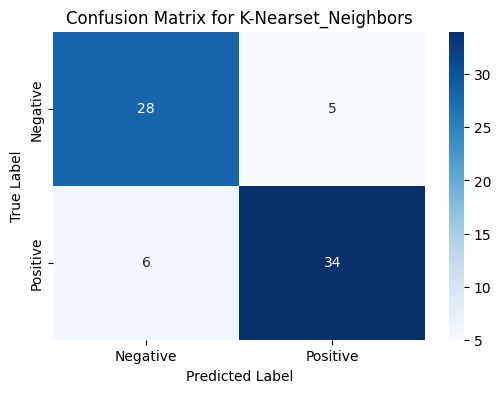


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix for Long Short Term Memory Train Data: 
[[21 12]
 [ 6 34]]


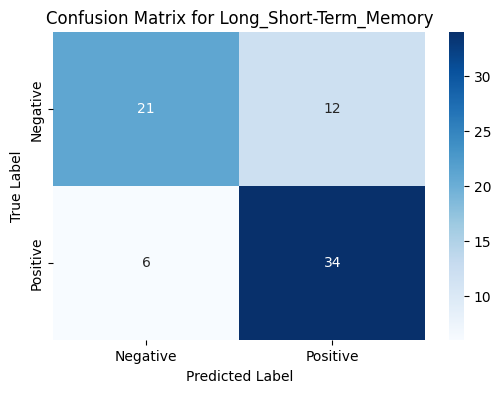


Fold Number: 7
Confusion Matrix for Random Forest Train Data: 
[[28  5]
 [ 4 36]]


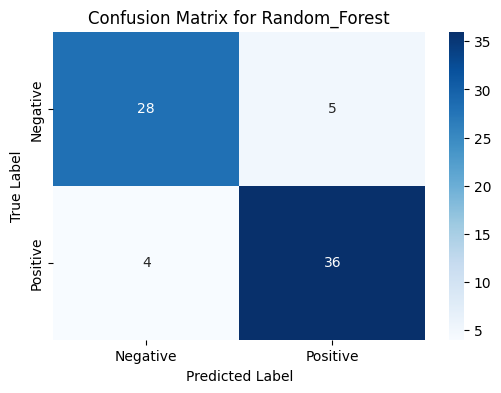


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[29  4]
 [ 3 37]]


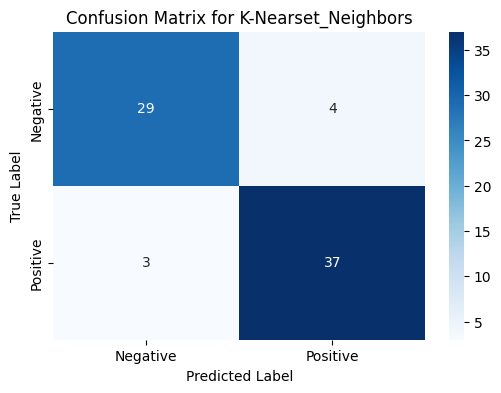


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix for Long Short Term Memory Train Data: 
[[21 12]
 [ 6 34]]


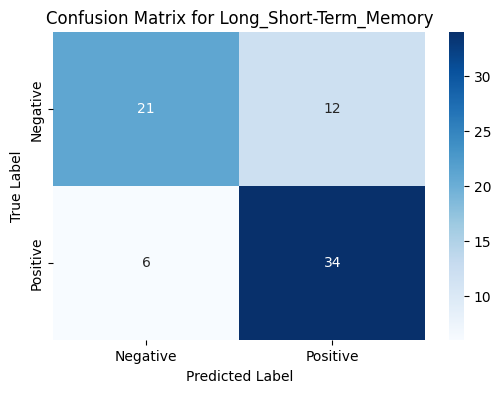


Fold Number: 8
Confusion Matrix for Random Forest Train Data: 
[[29  4]
 [ 2 38]]


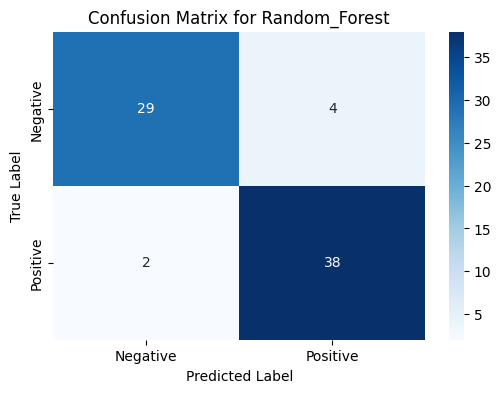


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[26  7]
 [ 6 34]]


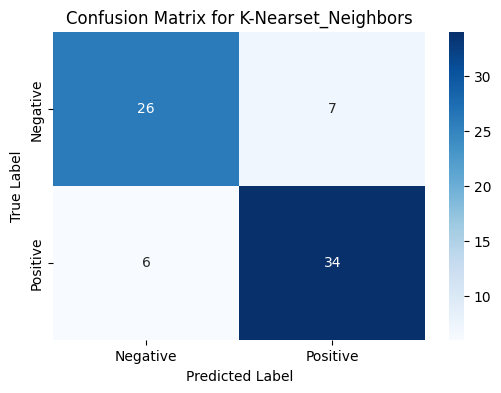


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Confusion Matrix for Long Short Term Memory Train Data: 
[[16 17]
 [ 2 38]]


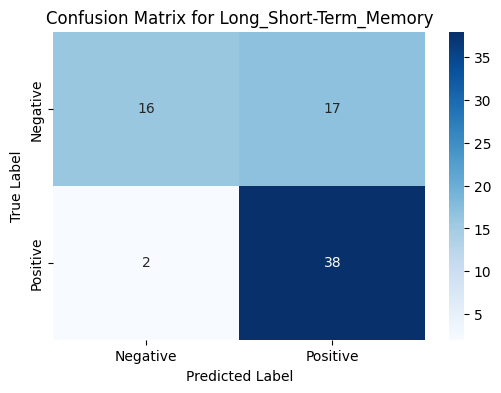


Fold Number: 9
Confusion Matrix for Random Forest Train Data: 
[[27  6]
 [ 5 35]]


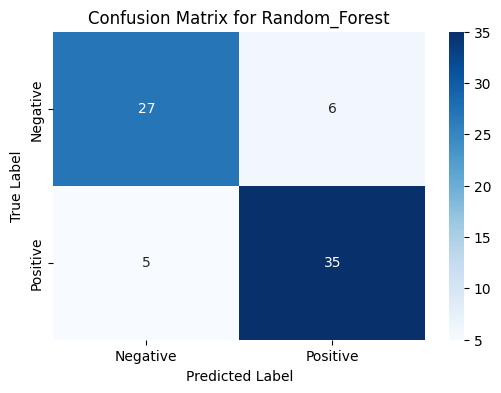


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[26  7]
 [ 3 37]]


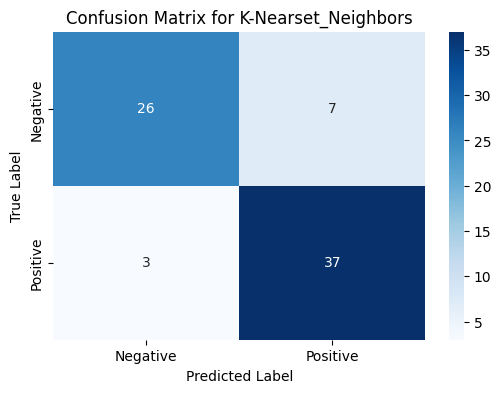


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix for Long Short Term Memory Train Data: 
[[25  8]
 [15 25]]


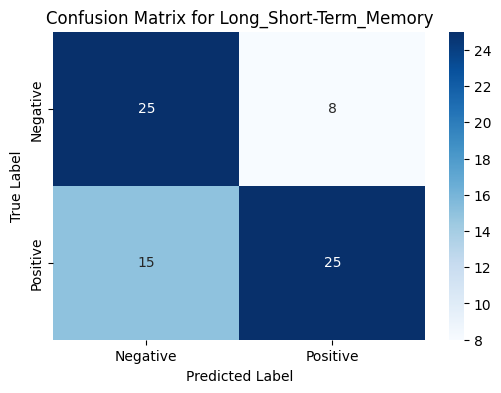


Fold Number: 10
Confusion Matrix for Random Forest Train Data: 
[[29  4]
 [ 4 36]]


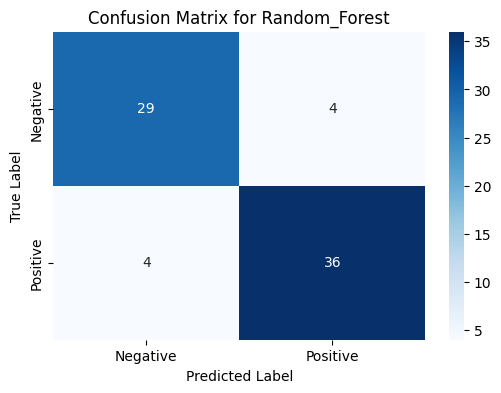


Confusion Matrix for K-Nearest Neighbor Train Data: 
[[29  4]
 [ 7 33]]


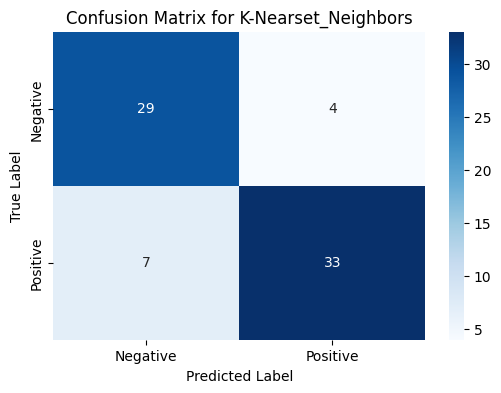


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix for Long Short Term Memory Train Data: 
[[21 12]
 [10 30]]


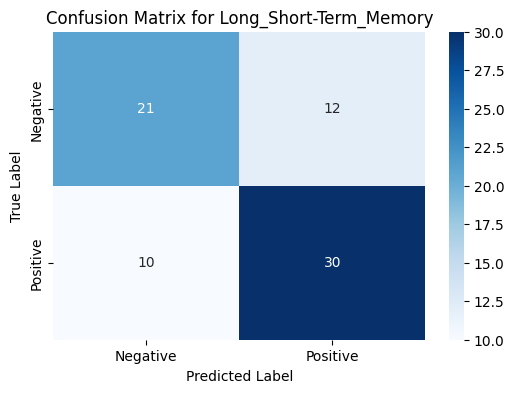

In [24]:
# Implementing StratifiedKFold as the Data is imbalanced
kFold_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for iterNum, (heartTrainInd, heartTestInd) in enumerate(kFold_stratified.split(heartFeat_Train, heartTarg_Train), 1):
    print(f"Fold Number: {iterNum}")
    fold.append(f"Fold_{iterNum}")
    
    # Splitting the Data for folds
    heartFeat_TrainFold, heartFeat_TestFold = heartFeat_Train.iloc[heartTrainInd], heartFeat_Train.iloc[heartTestInd]
    heartTarg_TrainFold, heartTarg_TestFold = heartTarg_Train.iloc[heartTrainInd], heartTarg_Train.iloc[heartTestInd]
    
    # Normalizing the Training and Test Data
    scaler = StandardScaler()
    heartFeat_TrainFold_std = scaler.fit_transform(heartFeat_TrainFold)
    heartFeat_TestFold_std = scaler.transform(heartFeat_TestFold)
    
    # Reshaping the Dataset for LSTM
    heartFeat_TrainFold_lstm = heartFeat_TrainFold_std.reshape(-1, heartFeat_TrainFold_std.shape[1], 1)
    heartFeat_TestFold_lstm = heartFeat_TestFold_std.reshape(-1, heartFeat_TestFold_std.shape[1], 1)
    
    # Random Forest Implementation
    rMetrics = randomForest("Random_Forest", rFtrain_Lt, heartFeat_TrainFold_std, heartTarg_TrainFold, heartFeat_TestFold_std, heartTarg_TestFold)
    
    # KNN Implementation
    knnMetrics = kNearest_Neighbors("K-Nearset_Neighbors", kNNtrain_Lt, heartFeat_TrainFold_std, heartTarg_TrainFold, heartFeat_TestFold_std, heartTarg_TestFold)
    
    # Long Short Term Memory (LSTM) Implementation
    lstmMetrics = lSTM("Long_Short-Term_Memory", lstmtrain_Lt, heartFeat_TrainFold_lstm, heartTarg_TrainFold, heartFeat_TestFold_lstm, heartTarg_TestFold)

In [25]:
# Converting Each Algorithm metrics to DataFrame
rF_df = pd.DataFrame(rMetrics).T
rF_df.columns = fold
kNN_df = pd.DataFrame(knnMetrics).T
kNN_df.columns = fold
lstm_df = pd.DataFrame(lstmMetrics).T
lstm_df.columns = fold

In [26]:
# Printing the Performance Metrics for each Algorithm for each Fold
print(f"Performance Metrics for 'Random Forest' Algorithm Using Stratified KFold for each Fold: \n{rF_df}\n")
print(f"Performance Metrics for 'K-Nearest Neighbor' Algorithm Using Stratified KFold for each Fold: \n{kNN_df}\n")
print(f"Performance Metrics for 'Long Short Term Memory (LSTM)' Algorithm Using Stratified KFold for each Fold: \n{lstm_df}\n")

Performance Metrics for 'Random Forest' Algorithm Using Stratified KFold for each Fold: 
                                Fold_1     Fold_2     Fold_3     Fold_4  \
True Positive (TP)           33.000000  38.000000  34.000000  36.000000   
True Negative (TN)           30.000000  29.000000  29.000000  24.000000   
False Positive (FP)           4.000000   5.000000   5.000000   9.000000   
False Negative (FN)           7.000000   2.000000   6.000000   5.000000   
Sensitivity (TPR)             0.825000   0.950000   0.850000   0.878049   
Specificity (TNR)             0.882353   0.852941   0.852941   0.727273   
False Positive Rate (FPR)     0.117647   0.147059   0.147059   0.272727   
False Negative Rate (FNR)     0.175000   0.050000   0.150000   0.121951   
Recall (r)                    0.825000   0.950000   0.850000   0.878049   
Precision (P)                 0.891892   0.883721   0.871795   0.800000   
F1 Measure (F1)               0.857143   0.915663   0.860759   0.837209   
Accuracy   

In [27]:
# Printing Average for each Algorithm
rFAvg_df = rF_df.mean(axis=1)
kNNAvg_df = kNN_df.mean(axis=1)
lstmAvg_df = lstm_df.mean(axis=1)
avgPerformDF = pd.DataFrame({"Random Forest": rFAvg_df, "K-Nearest Neighbor": kNNAvg_df, "Long Short Term Memory (LSTM)": lstmAvg_df})
print(f"Comparing Average Performance Metrics for 'Random Forest', 'K-Nearest Neighbor', 'Long Short Term Memory (LSTM)' Algorithms Using Stratified KFold on Training Data: \n{avgPerformDF}\n")

Comparing Average Performance Metrics for 'Random Forest', 'K-Nearest Neighbor', 'Long Short Term Memory (LSTM)' Algorithms Using Stratified KFold on Training Data: 
                             Random Forest  K-Nearest Neighbor  \
True Positive (TP)               35.300000           35.700000   
True Negative (TN)               27.800000           27.400000   
False Positive (FP)               5.500000            5.900000   
False Negative (FN)               4.800000            4.400000   
Sensitivity (TPR)                 0.880305            0.890244   
Specificity (TNR)                 0.834581            0.822727   
False Positive Rate (FPR)         0.165419            0.177273   
False Negative Rate (FNR)         0.119695            0.109756   
Recall (r)                        0.880305            0.890244   
Precision (P)                     0.865888            0.859546   
F1 Measure (F1)                   0.872569            0.873719   
Accuracy                          0.859700

In [29]:
# Normalizing for evaluating the Testing Data
scaler = StandardScaler()
heartFeat_Train_teststd = scaler.fit_transform(heartFeat_Train)
heartFeat_Test_teststd = scaler.transform(heartFeat_Test)

In [30]:
rFtest_Lt = []
kNNtest_Lt = []
lstmtest_Lt = []

Confusion Matrix for Random Forest Test Data: 
[[66 11]
 [11 96]]


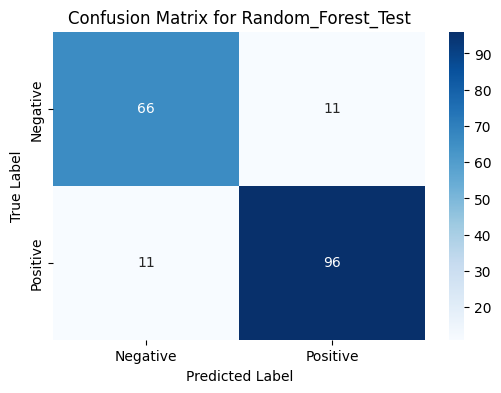

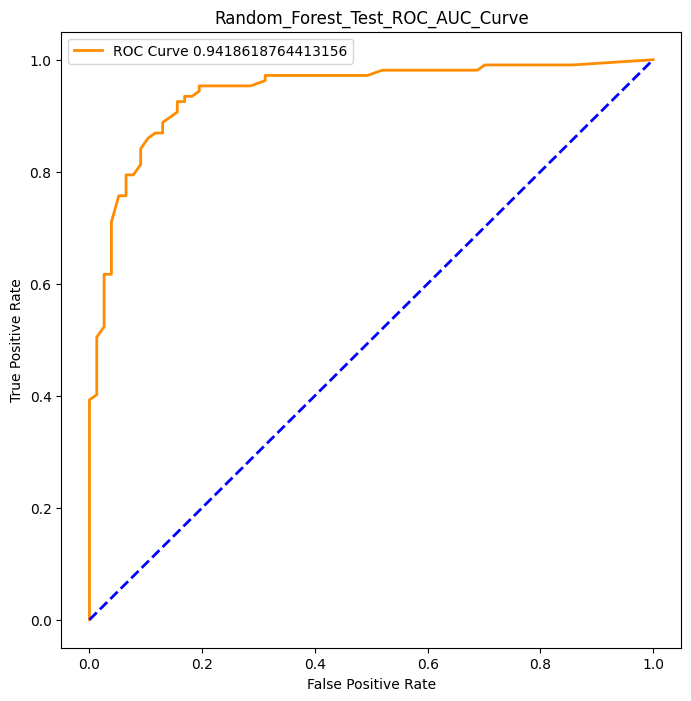


Confusion Matrix for K-Nearest Neighbor Test Data: 
[[67 10]
 [18 89]]


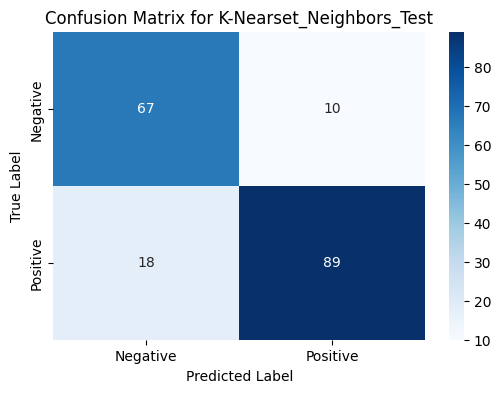

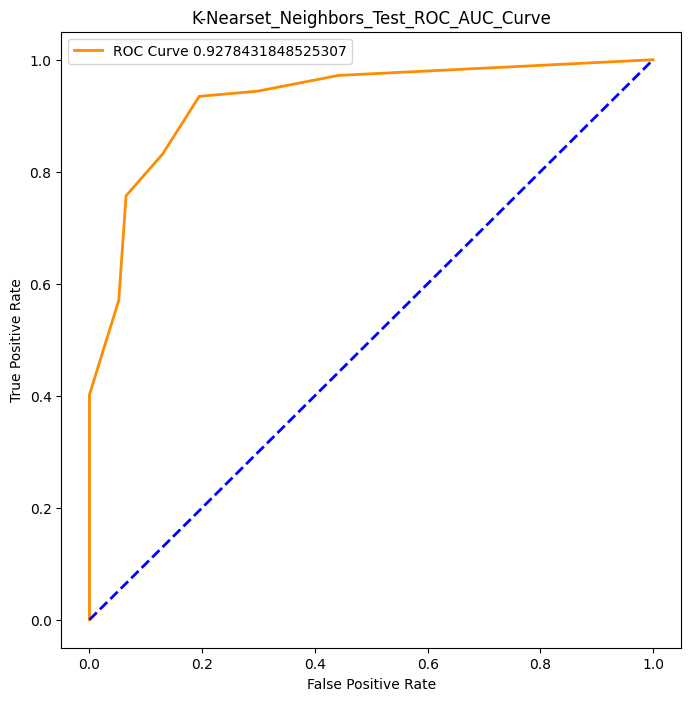


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Confusion Matrix for Long Short Term Memory Test Data: 
[[65 12]
 [25 82]]


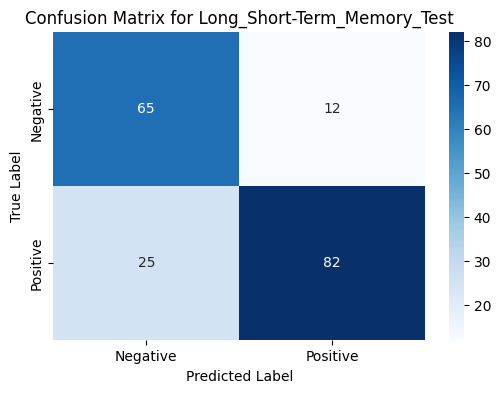

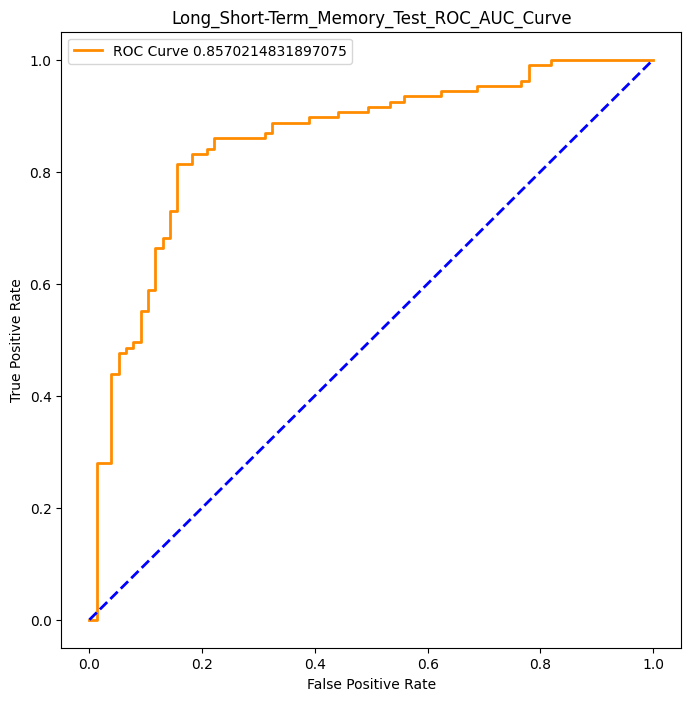

In [31]:
# Reshaping the Test Data for LSTM
heartFeat_Traintest_lstm = heartFeat_Train_teststd.reshape(-1, heartFeat_Train_teststd.shape[1], 1)
heartFeat_Testtest_lstm = heartFeat_Test_teststd.reshape(-1, heartFeat_Test_teststd.shape[1], 1)

# Random Forest Implementation on Test Data
rTest = randomForest("Random_Forest_Test", rFtest_Lt, heartFeat_Train_teststd, heartTarg_Train, heartFeat_Test_teststd, heartTarg_Test)
    
# KNN Implementation on Test Data
kTest = kNearest_Neighbors("K-Nearset_Neighbors_Test", kNNtest_Lt, heartFeat_Train_teststd, heartTarg_Train, heartFeat_Test_teststd, heartTarg_Test)

# Long Short Term Memory (LSTM) Implementation on Test Data
lTest = lSTM("Long_Short-Term_Memory_Test", lstmtest_Lt, heartFeat_Traintest_lstm, heartTarg_Train, heartFeat_Testtest_lstm, heartTarg_Test)

In [32]:
# Converting Each Algorithm metrics to DataFrame for Test Data
rFtest_df = pd.DataFrame(rTest).T
kNNtest_df = pd.DataFrame(kTest).T
lstmtest_df = pd.DataFrame(lTest).T

In [33]:
# Performance Metrics for Test Data
testPerformDF = pd.concat([rFtest_df, kNNtest_df, lstmtest_df], axis=1)
algorithms = ['Random Forest', 'K-Nearest Neighbor', 'Long Short Term Memory (LSTM)']
testPerformDF.columns = algorithms
print(f"Comparing Performance Metrics for 'Random Forest', 'K-Nearest Neighbor', 'Long Short Term Memory (LSTM)' Algorithms on Testing Data: \n{testPerformDF}\n")

Comparing Performance Metrics for 'Random Forest', 'K-Nearest Neighbor', 'Long Short Term Memory (LSTM)' Algorithms on Testing Data: 
                             Random Forest  K-Nearest Neighbor  \
True Positive (TP)               96.000000           89.000000   
True Negative (TN)               66.000000           67.000000   
False Positive (FP)              11.000000           10.000000   
False Negative (FN)              11.000000           18.000000   
Sensitivity (TPR)                 0.897196            0.831776   
Specificity (TNR)                 0.857143            0.870130   
False Positive Rate (FPR)         0.142857            0.129870   
False Negative Rate (FNR)         0.102804            0.168224   
Recall (r)                        0.897196            0.831776   
Precision (P)                     0.897196            0.898990   
F1 Measure (F1)                   0.897196            0.864078   
Accuracy                          0.880435            0.847826   
Error Ra

In [40]:
# Best Accuracy
accuracy_Dt = {"Random Forest": rTest[0]["Accuracy"], "K-Nearest Neighbor": kTest[0]["Accuracy"], "Long Short Term Memory (LSTM)": lTest[0]["Accuracy"]}
max_Accuracy = max(accuracy_Dt, key=accuracy_Dt.get)
print(f"{max_Accuracy} has more Accuracy among all three algorithm which is {accuracy_Dt[max_Accuracy] * 100}% on Test Data")

Random Forest has more Accuracy among all three algorithm which is 88.04347826086956% on Test Data


In [41]:
# Best Accuracy on Train Data
accuracyTr_Dt = {"Random Forest": rFAvg_df["Accuracy"], "K-Nearest Neighbor": kNNAvg_df["Accuracy"], "Long Short Term Memory (LSTM)": lstmAvg_df["Accuracy"]}
max_AccuracyTr = max(accuracyTr_Dt, key=accuracyTr_Dt.get)
print(f"{max_AccuracyTr} has more Accuracy among all three algorithm which is {accuracyTr_Dt[max_AccuracyTr] * 100}% on Train Data")

Random Forest has more Accuracy among all three algorithm which is 85.97001110699742% on Train Data
